In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
# Pkg.add("ForwardDiff")
# Pkg.add("RobotDynamics")
# Pkg.add("LinearAlgebra")
# Pkg.add("StaticArrays")
# Pkg.add("SparseArrays")
# Pkg.add("Plots")
# Pkg.add("Printf")
using ForwardDiff
using Test
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
# using PyPlots
using Printf

# include("quadratic_cost.jl")


 Activating environment at `F:\Documents\Schoolwork\optimalControl\16-745_final_project\Project.toml`
┌ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1278
┌ Info: Precompiling RobotDynamics [38ceca67-d8d3-44e8-9852-78a5596522e1]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


# Final Project Info
In this we present a geostationary transfer orbit to a geosynchronous (GSO) or geostationary orbit (GEO).  We use Keplerian Orbital Dynamics to model our system. We make several assumptions like Earth Reference Frame, Spherical Earth, Kepler Dynamics. 

## The Model
We'll be using the Kepler Dynamics:

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$$ 
\ddot{r} = F = \frac{-\mu}{\norm{r}^3}*r+u \\
x = [r, \dot{r}] \\
\norm{u} \le Tmax
$$
with the following model parameters:
* $\mu$: Gravitational Parameter = 63781
* $r$: distance to earth center
* $u$: control of ion thruster

In [3]:
# Problem Setup
# Dont want KM and S
# Rescale unite to order 1
# Length unit = SMA 
# Time scale = T orbit period
# Helps condition number 

# TODO Rescale μ 
# Hint can take big steps 10 knot points per-orbit

struct Orbit{T}
    semiMajorAxis::T
    period::T
    perigee::T #closest radius to earth
    perigee_V::T #velocity at perigee
    x0::Vector{T}
#     function Orbit(x0) 
#         print(x0) #best is to input point with velocity and calucate useful parts of orbit
#     end
end

# GTO =  Orbit(x0)


function func(orbit::Orbit)
    return orbit
end



# model = Kepler() # TODO
# n,m = size(model)          # state and control dimensions
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

# Initial & final condition

#cartesian and ECI
#x,y,z,vx,vy,vz
earthRadius_km = 6378.1 # [km]
LEO_km = 500 #km above sealevel #circular low earth orbit # 250km 
GSO_km = 35786 #km above sealevel #circular geosychonous orbit
μ_km_s = 3.986*10e5 #gravitational0 parameter [km^3 / s^2]
semiMajorAxis_scale = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/2
period_scale = sqrt(semiMajorAxis_scale^3/μ_km_s)*2*pi
μ = μ_km_s*period_scale^2/semiMajorAxis_scale^3  #μ(OU^3/P^2)


39.47841760435743

In [4]:
semiMajorAxis_transfer = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/(2*semiMajorAxis_scale) #OU
instantRadius_transfer = (earthRadius_km+LEO_km) / semiMajorAxis_scale # #OU
instantVelocity_transfer = sqrt(μ*(2.0/instantRadius_transfer-1.0/semiMajorAxis_transfer)) #sqrt(OU^3/P^2/OU) =OU/P
period_transfer = sqrt(semiMajorAxis_transfer^3/μ)*2*pi
x0    = [instantRadius_transfer, 0.0, 0.0, 0.0, instantVelocity_transfer, 0.0] # initial state #geosynchronous transfer orbit (GTO, where rocket dropped satellite off)
                                                                             #many kilometers above Africa in an elliptical orbit 
transfer_orbit = Orbit(semiMajorAxis_transfer, period_transfer, instantRadius_transfer, instantVelocity_transfer, x0)

Orbit{Float64}(1.0, 1.0, 0.28049720444841386, 15.556684458046954, [0.28049720444841386, 0.0, 0.0, 0.0, 15.556684458046954, 0.0])

In [5]:
semiMajorAxis_goal = 2*(earthRadius_km+GSO_km)/(2*semiMajorAxis_scale)
instantRadius_goal = (earthRadius_km+GSO_km) / semiMajorAxis_scale
instantVelocity_goal = sqrt(μ*(2.0/instantRadius_goal-1.0/semiMajorAxis_goal)) # VisViva
period_goal = sqrt(semiMajorAxis_goal^3/μ)*2*pi
xgoal = [instantRadius_goal, 0.0, 0.0, 0.0, instantVelocity_goal, 0.0] # goal state #circular geosychonous orbit above africa
goal_orbit = Orbit(semiMajorAxis_goal, period_goal, instantRadius_goal, instantVelocity_goal, xgoal)
ugto = zeros(3)                  # hover controls

# Cost matrices
# Q = #TODO  #Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
# R = #TODO  #Diagonal(@SVector fill(1e-2, m))
# Qf = #TODO #Diagonal(@SVector fill(1e2, n));

In [ ]:
sqrt(4*3.14159^2*instantRadius^3/μ)

In [ ]:
period = sqrt(semiMajorAxis_goal^3/μ)*2*pi

In [ ]:
pi

## Dynamics

In [6]:
function dynamics(x, u)
    # x = state [x, y, z, dx, dy, dz]
    # u = control [ux, uy, uz]
    r = x[1:3] #orbital units (OU)
    ṙ = x[4:end] #
    r̈ = (-μ/(norm(r)^3))*r + u #μ(OU^3/P^2)/OU^3*OU
    return [ṙ; r̈]
end

dynamics (generic function with 1 method)

In [7]:
function integrator!(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    x .+= (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

integrator! (generic function with 1 method)

In [8]:
function get_energy(x)
    return norm(x[4:end])^2/2 - μ/norm(x[1:3])
end

get_energy (generic function with 1 method)

In [27]:
function plot_orbit(orbit::Orbit)
    h = 0.001 
    t = range(0, orbit.period, step=h) # time in second 90min

    traj = zeros(size(t)[1], size(x0)[1])
    # print(size(traj))
    x = copy(orbit.x0)
    traj[1,:] .= x

    u = zeros(3)
    energy = zero(t)
    energy[1] = get_energy(x)
    for i in 2:size(t)[1]
        integrator!(x, u, h)
        traj[i,:] .= x
        energy[i] = get_energy(x)
    end
#     plot(t, energy)
    plot(traj[:, 1], traj[:, 2], aspect_ratio=:equal, lims=(-semiMajorAxis_goal,semiMajorAxis_goal))
end

plot_orbit (generic function with 1 method)

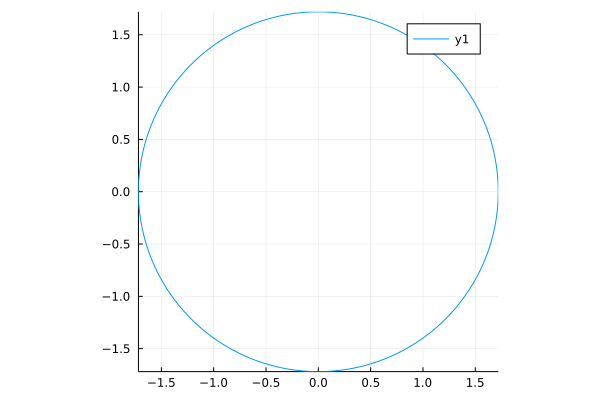

In [29]:
# plot(t, energy)
plot_orbit(goal_orbit)

## Part (a): Implement DIRCOL 
Implement DIRCOL by completing the provided methods. 

In [ ]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
struct Problem{n,m,L}
    # TODO 
end
Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

In [ ]:
# Cost function
# TODO 

# Build Problem
prob = Problem(model, obj, tf, x0);
n,m,T = size(prob)   # get problem dimensions

# Random trajectory
Xrand =  # TODO 
Urand = # TODO 

# Evaluate the cost
# t = prob.times[1]
# dt = prob.times[2]-prob.times[1]
# cost(prob.obj, Xrand, Urand)

# Evaluate the dynamics
# TODO

### DIRCOL Algorithm

In [ ]:
# TASK: Complete implement DIRCOL Algo



### Forward Pass

In [ ]:
# TASK: Complete forward simulation of satelite 

## Part (b): Simple trajectory 
Planar example with quibit interpolation and no Thurst conditions

In [ ]:
# Task Solve Simple Trajectory

In [ ]:
# vis = Visualizer()
# set_mesh!(vis, model)
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xline)

## Part (c): Higher Order DIRCOL
Solve the simple planar problem with unconstrained thrust with higher order DIRCOL 3->8th order

In [ ]:
# TASK: Implement the following method

In [ ]:
# TASK: Plot the comparison


## Part (d): Inequality Constraints 
Using the thruster constraints solve the optimization problem

In [ ]:
# TASK: Inequality constraints

In [ ]:
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xflip)

## Part (e): Non-Planar Satellite Control


In [ ]:
# TASK: Non-Planar Control

## TESTS

In [ ]:
# run_tests();